In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from general_qec.qec_helpers import *
from general_qec.gates import *
from general_qec.errors import *

# Modelling and simulating noisy quantum computers
https://arxiv.org/pdf/2101.02109.pdf

## Contents
1. [Introduction](#introduction)
2. [Depolarizing Channel](#depolarize)
    1. [Single qubit gate model](#single)
    2. [Two qubit gate model](#two)
    3. [Implementing line connectivity](#line)
1. [State Preparation and Measuremnt](#spam)
2. [Thermal Decoherence and Dephasing Channel](#t)
    1. [Implementation of T1 and T2 induced errors](#implement)
        1. [Single qubit gates with relaxation and dephasing](#singlerad)
        2. [Two qubit gates with relaxation and dephasing](#tworad)
        3. [Implementing line connectivity](#linerad)

## 1. Introduction <a id='introduction'></a>
In this noteboook we will introduce imlement the error models shown in the paper arXiv:2101.02109. These errors are similar to the ones discussed in  <u>01. Introduction to Quantum Error</u>.

## 2. Depolarizing Channel <a id='depolarize'></a>
### Simulates bit and phase flips due to gate infidelities with in the circuit (probability $p_1$)
$$ K_{D_0} = \sqrt{1-p_1}, \quad K_{D_1} = \sqrt{\frac{p_1}{3}}X, \quad K_{D_2} = \sqrt{\frac{p_1}{3}}Z, \quad K_{D_3} = \sqrt{\frac{p_1}{3}}Y$$
$$ \rho \mapsto D(\rho) = \sum_{i = 0}^{3}K_{D_i}\rho K^\dagger_{D_i}$$


<u>Single qubit gate model:</u> <a id='single'></a> error after single qubit gate according to single qubit error rates

This example will show a hadamard gate but all other single qubit gate operations will work similarly.

In [26]:
psi = np.array([1, 0]) # initial state of our qubit
rho = np.kron(psi, psi[np.newaxis].conj().T) # convert to density matrix
p_1 = 0.0001 # probability of gate error
rho_prime = np.dot(sigma_x, np.dot(rho, sigma_x.conj().T)) # apply 'perfect gate'

final_rho = qubit_gate_error_matrix(rho_prime, p_1, 0, 1) # apply errored gate operation
print('Density Matrix after errored gate operation: \n', final_rho)

Density Matrix after errored gate operation: 
 [[6.66666667e-05+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 9.99933333e-01+0.j]]


total probabilities:  1.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


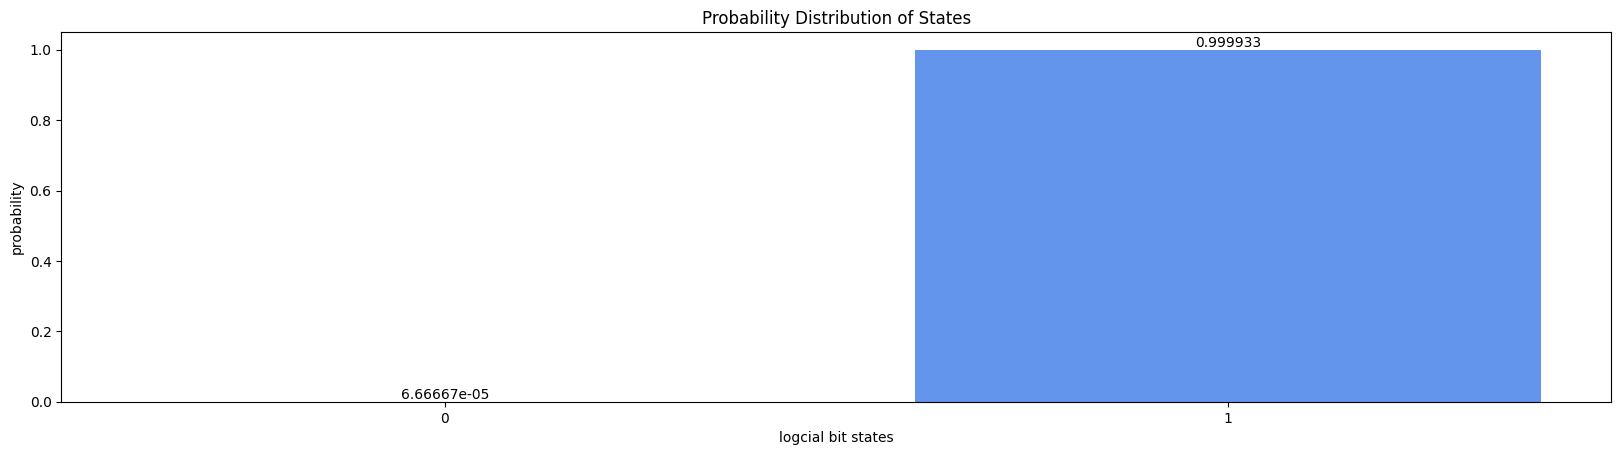

In [27]:
# probability of the state measurments from the density matrix are defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(final_rho)):
    prob_sum += np.abs(final_rho[i,i])
    state_probs = np.append(state_probs, final_rho[i,i])
    
print('total probabilities: ', prob_sum)

bits = vector_state_to_bit_state(state_probs, 1)[0]

# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, state_probs, label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

<u> Two qubit gate model:</u> <a id='two'></a>Error occurs after a two qubit gate according to two qubit error rates


This example will use a CNOT matrix between 2 qubits in a 3 qubit system. We will first show all-to-all connectivity and then restrict to line to line (after that grid will work similarly to both of these)

In [31]:
# In both examples we will use the following information #
zero = np.array([1, 0])
one = np.array([0, 1])
psi = np.kron(one, np.kron(zero, one)) # set an initial_state
rho = np.kron(psi, psi[np.newaxis].conj().T) # find the density matrix

# probability of gate error for each qubit:
p_q0 = 0.00001
p_q1 = 0.00001
p_q2 = 0.00001

error_probs = np.array([p_q0, p_q1, p_q2])

total probability:  1.0


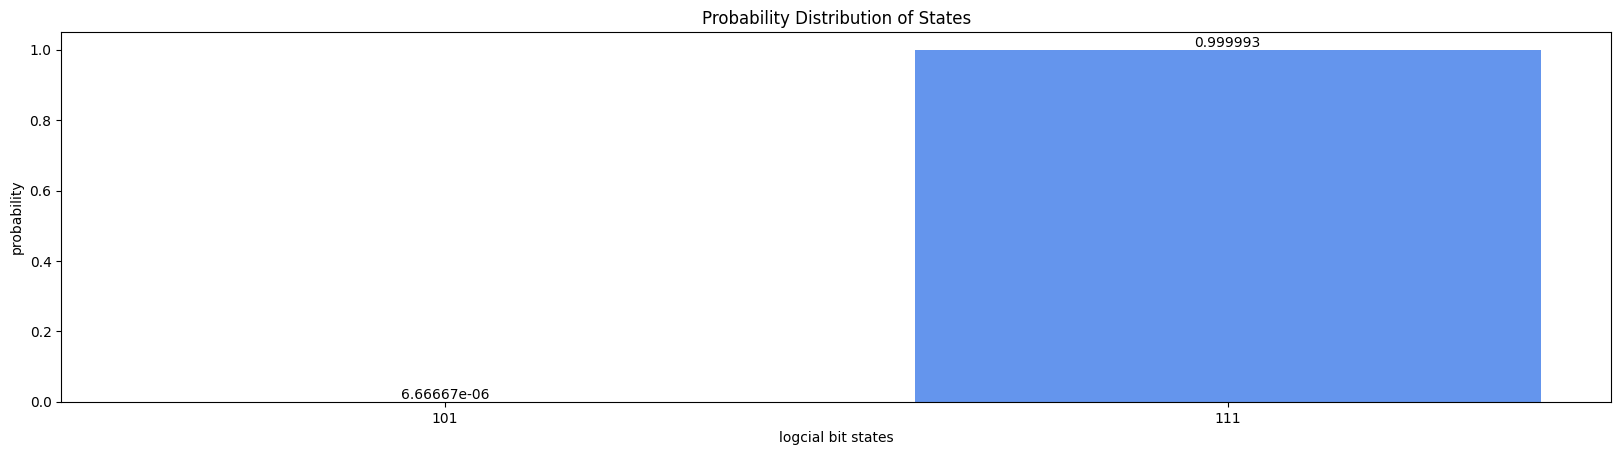

In [32]:
# 2 adjacent qubits all-to-all connectivity CNOT gate example #
cnot_gate = CNOT(0, 1, 3) # CNOT gate with q0 as control and q1 as target

rho_prime = np.dot(cnot_gate, np.dot(rho, cnot_gate.conj().T)) # apply our 'perfect' cnot gate

final_rho = qubit_gate_error_matrix(rho_prime, p_q1, 1, 3) # apply our error gate

# probability of the state measurments from the density matrix are defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(final_rho)):
    prob_sum += np.abs(final_rho[i,i])
    state_probs = np.append(state_probs, final_rho[i,i])
    
print('total probability: ', prob_sum)

bits = vector_state_to_bit_state(state_probs, 3)[0]

# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, state_probs[state_probs!=0], label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

total probabilities:  1.0


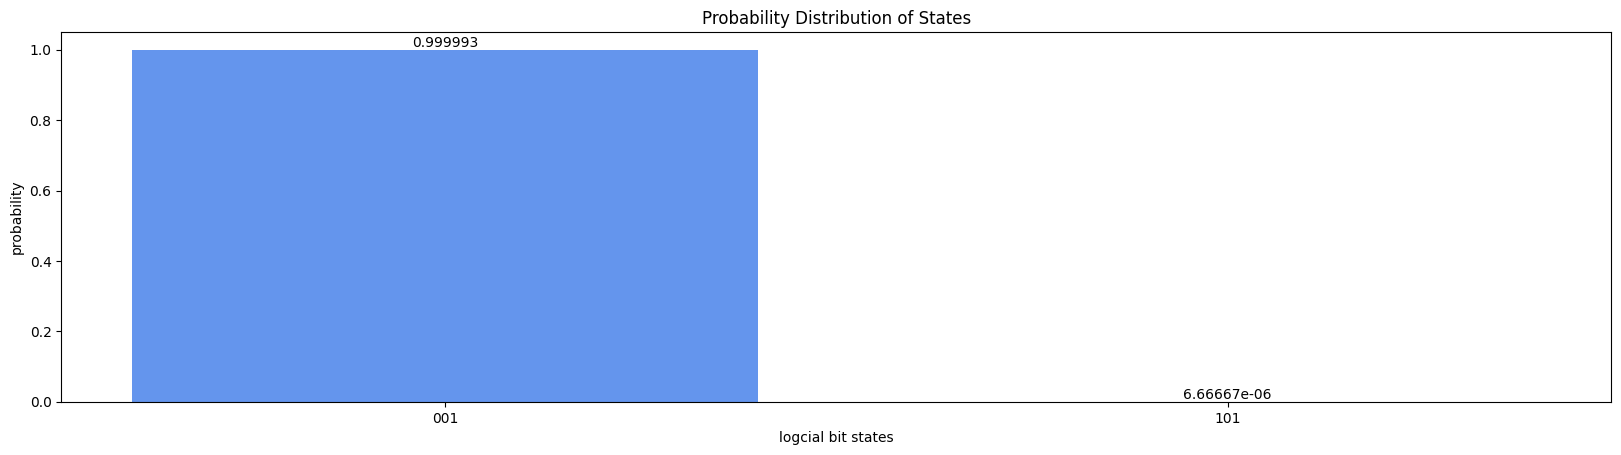

In [33]:
# 2 non-adjacent qubits all-to-all connectivity CNOT gate example #
cnot_gate = CNOT(2, 0, 3) # CNOT gate with q2 as control and q0 as target

rho_prime = np.dot(cnot_gate, np.dot(rho, cnot_gate.conj().T)) # apply our cnot gate

final_rho = qubit_gate_error_matrix(rho_prime, p_q0, 0, 3) # apply our error gate

# probability of the state measurments from the density matrix are defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(final_rho)):
    prob_sum += np.abs(final_rho[i,i])
    state_probs = np.append(state_probs, final_rho[i,i])
    
print('total probabilities: ', prob_sum)

bits = vector_state_to_bit_state(state_probs, 3)[0]

# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, state_probs[state_probs!=0], label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

Now focussing on <u>line connectivity</u>. <a id='line'></a>We will use our current CNOT functions to create new ones that implement the errors that occur after each gate is applied in the derivations.

total probability:  1.0


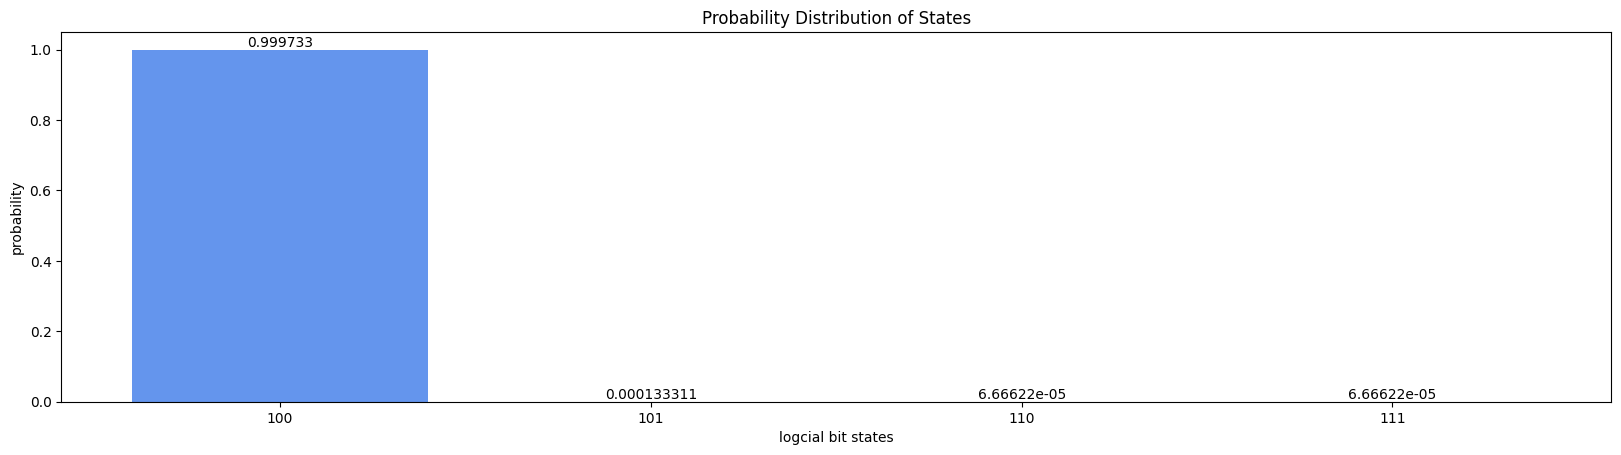

In [34]:
# 2 non-adjacent qubits line connectivity CNOT gate example #
# CNOT gate with q0 as control and q2 as target
psi = np.kron(one, np.kron(zero, one))

# probability of gate error for each qubit:
p_q0 = 0.0001
p_q1 = 0.0001
p_q2 = 0.0001

# define your error probability for each qubit
qubit_error_probs = np.array([p_q0, p_q1, p_q2])

# apply an errored line connected CNOT gate
rho_prime = line_errored_CNOT(psi, 0, 2, qubit_error_probs, form = 'psi') 

# probability of the density matrix is defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(rho_prime)):
    prob_sum += np.abs(rho_prime[i,i])
    state_probs = np.append(state_probs, rho_prime[i,i])
    
print('total probability: ', prob_sum)
bits = vector_state_to_bit_state(state_probs, 3)[0]

# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, state_probs[state_probs!=0], label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

total probability:  1.0000000000000007


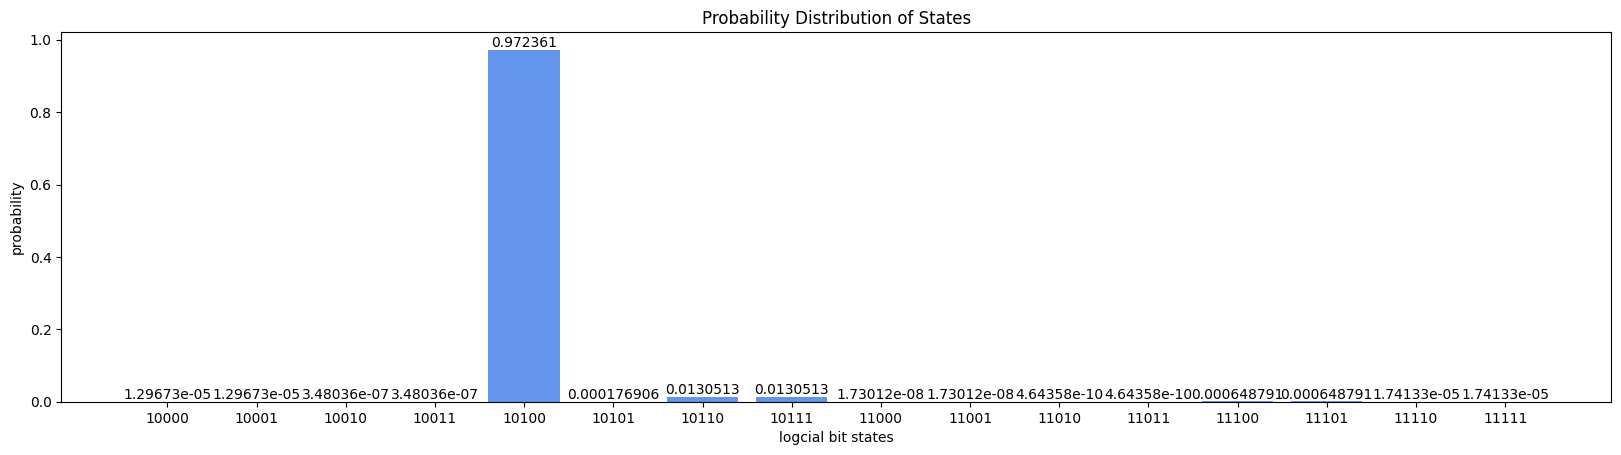

In [35]:
# 2 non-adjacent qubits line connectivity CNOT gate example with 5 qubits #
# CNOT gate with q0 as control and q2 as target
psi = np.kron(one, np.kron(zero, np.kron(one, np.kron(zero, one))))

# probability of gate error for each qubit:
p_q0 = 0.0001
p_q1 = 0.001
p_q2 = 0.00001
p_q3 = 0.01
p_q4 = 0.000001

# define your error probability for each qubit
qubit_error_probs = np.array([p_q0, p_q1, p_q2, p_q3, p_q4])

# apply an errored line connected CNOT gate
rho_prime = line_errored_CNOT(psi, 0, 4, qubit_error_probs, form = 'psi')

# probability of the density matrix is defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(rho_prime)):
    prob_sum += np.abs(rho_prime[i,i])
    state_probs = np.append(state_probs, rho_prime[i,i])
    
print('total probability: ', prob_sum)
bits = vector_state_to_bit_state(state_probs, 5)[0]

# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, state_probs[state_probs!=0], label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

## 2. State Preparation and Measuremnt <a id='spam'></a>

## 3. Thermal Decoherence and Dephasing Channel <a id='t'></a>

### Each qubit in our system has their own relaxation and dephasing which both occur over time.
#### <u>Relaxation</u> is the energy exchange between the qubit and the environment (also known as decoherence) along the x and y axis of the bloch sphere - it is irreversible
- The time it takes a gubit to relax is known as $T_1$ and is defined by the evolution towards the equilibrium state at the temperature of the environment.

#### <u>Dephasing</u> is the transition of a quantum state to a classical one (also due to the environment) along the z axis of the bloch sphere
- The time it takes a gubit to dephase is known as $T_2$ and is defined by the behavior of off diagonal entries over time. Describes the behavior of coherence decaying over time.

$T_1$ and $T_2$ are related by the inequality $T_2(q) \le 2 T_1(q)$ where q is the index (starting at 0) of the qubit in our system


In our model we will include both of these channels. We can track the time in our circuit by using the average execution time for each gate operation, $T_g$. We know that the probability for each qubit to relax and dephase after a gate of time $T_g$ is given by: 

$$p_{T_1(q)} = e^{-T_g/T_1(q)}, \space and \space p_{T_2(q)} = e^{-T_g/T_2(q)}$$

respectively, where $(q)$ is the index of the qubit. These can be found by integrating over the functions $f_{T_1}(t) = \frac{1}{T_1}e^{-\frac{t}{T_1}}$ and  $f_{T_2}(t) = \frac{1}{T_2}e^{-\frac{t}{T_2}}$ over the interval $T_g \lt t \lt \infty$. And from this we can also know that that probability for a qubit to reset into an equillibrium state is 

$$p_{reset(q)} = 1 - p_{T_1(q)}$$

This is done by integrating $f_{T_1}(t) = \frac{1}{T_1}e^{-\frac{t}{T_1}}$ over the interval $0 \lt t \lt T_g$.

<u>Something that may be useful to know:</u>
We can take into account the thermal relaxation transition, and calculate the weight that dictates towards which of the two equilibrium states ($\vert0\rangle$ or $\vert1\rangle$) this noise (or reset error) drives each qubit, q, as 

$$ w_e(q) = \frac{1}{1 + e^{2hf_q/k_B\Theta}}$$

Where $h$ is Plank's constant, $f_q$ is the frequency of the qubit, $k_B$ is Boltzmann's constant, and $\Theta$ is the temperature of the quantum processor.

#### In our case we will assume that $\Theta = 0$. And we can safely assume that the error only resets our system to the ground state $\vert0\rangle$.

#### Lets allow $T_2(q) \le T_1(q)$ for every qubit in our system. We can now see that the forms of noise that we have in our system are:
#### <u>Dephasing</u> (phase flip) with a probability $p_Z = \frac{(1 - p_{reset})(1 - p_{T_2}p_{T_1}^{-1})}{2}$ defined by the operator $K_Z = \sqrt{p_Z}Z$

#### <u>Relaxation/Thermal Decay</u> (reset to the state $\vert0\rangle$) with a probability $p_{reset} = 1 - p_{T_1}$ defined by the operator $K_{reset} = \sqrt{p_{reset}} \vert0\rangle\langle0\vert$

#### <u> Identity Transforamtion </u> (nothing happens to the qubit) with a probability $ p_I = 1 - p_Z - p_{reset}$ defined by the operator $K_I = \sqrt{p_I}I$

#### Thus the effect of the relaxation channel on the density matrix $\rho$ in this case can be defined as $ \rho \mapsto \eta(\rho) = \sum_{k \in \left\{I, Z, reset\right\}}^{}K_{k}\rho K^\dagger_{k}$


The average $T_1$ and $T_2$ times for superconducting transmon qubits are around 100-200 $\mu s$ with gate times of 10s of nanoseconds.

So in this case we will allow $T_1$ for each qubit to be 200 $\mu s$ and $T_2$ to be 150 $\mu s$

We will have $T_g$ set to 20 nanoseconds for all gate operations because for superconducting transmon qubits this is about the average gate duration. But we can change this depending on different gate parameters in the future.

https://arxiv.org/abs/2212.06979 - gates

https://arxiv.org/pdf/2302.08690.pdf - t1/t2 and gates

https://unitary.fund/ - good general info


### A. Implementation of T1 and T2 induced errors <a id='implement'></a>

<u>Single qubit gates with relaxation and dephasing</u> <a id='singlerad'></a>

Density Matrix after errored gate operation: 
 [[0.     0.    ]
 [0.     0.9999]]
total probabilities:  0.9999000049998334


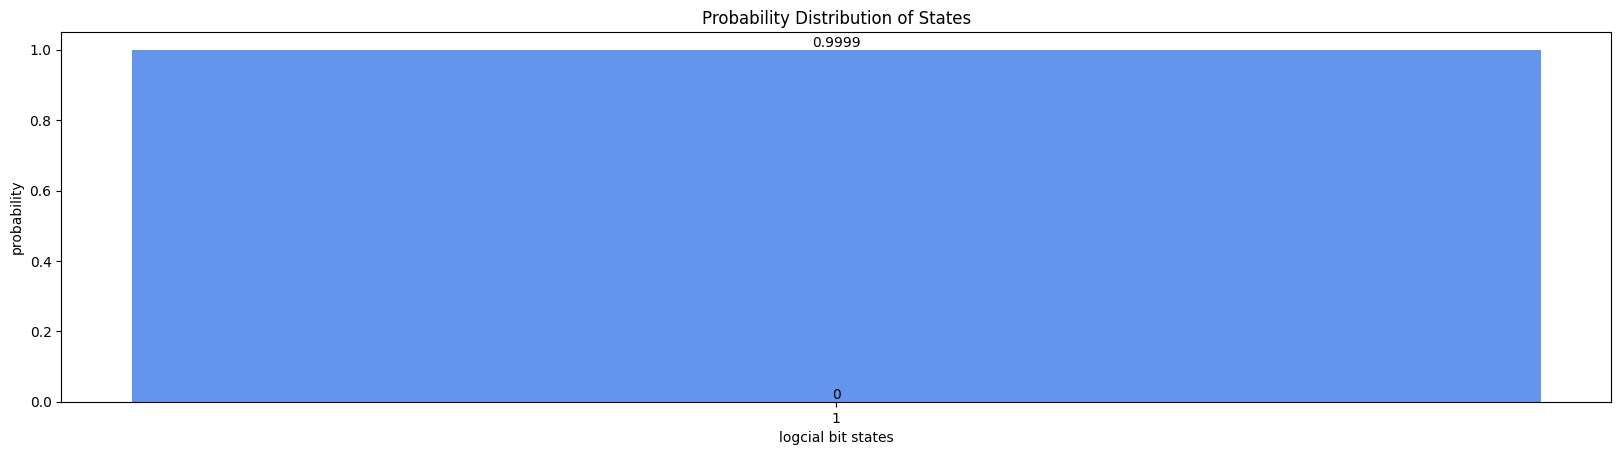

In [2]:
psi = np.array([1, 0]) # initial state of our qubit
rho = np.kron(psi, psi[np.newaxis].conj().T) # convert to density matrix

rho_prime = np.dot(sigma_x, np.dot(rho, sigma_x.conj().T)) # apply 'perfect gate'

t1 = 200 * 10**-6
t2 = 150 * 10**-6
tg = 20 * 10**-9

final_rho = qubit_rad_error_matrix(rho_prime, t1, t2, tg) # apply errored gate operation

print('Density Matrix after errored gate operation: \n', final_rho)


# probability of the state measurments from the density matrix are defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(final_rho)):
    prob_sum += np.abs(final_rho[i,i])
    state_probs = np.append(state_probs, final_rho[i,i])
    
print('total probabilities: ', prob_sum)

bits = vector_state_to_bit_state(state_probs, 1)[0]

# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, state_probs, label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

<u>Two qubit gates with relaxation and dephasing</u> <a id='tworad'></a>

First we implement a single gate to demonstrate the state after the operation.

In [3]:
# In both examples we will use the following information #
zero = np.array([1, 0])
one = np.array([0, 1])
psi = np.kron(one, np.kron(zero, one)) # set an initial_state
rho = np.kron(psi, psi[np.newaxis].conj().T) # find the density matrix

# parameters set for all qubits:
t1 = 200 * 10**-6
t2 = 150 * 10**-6
tg = 20 * 10**-9


total probability:  0.9996500616593808


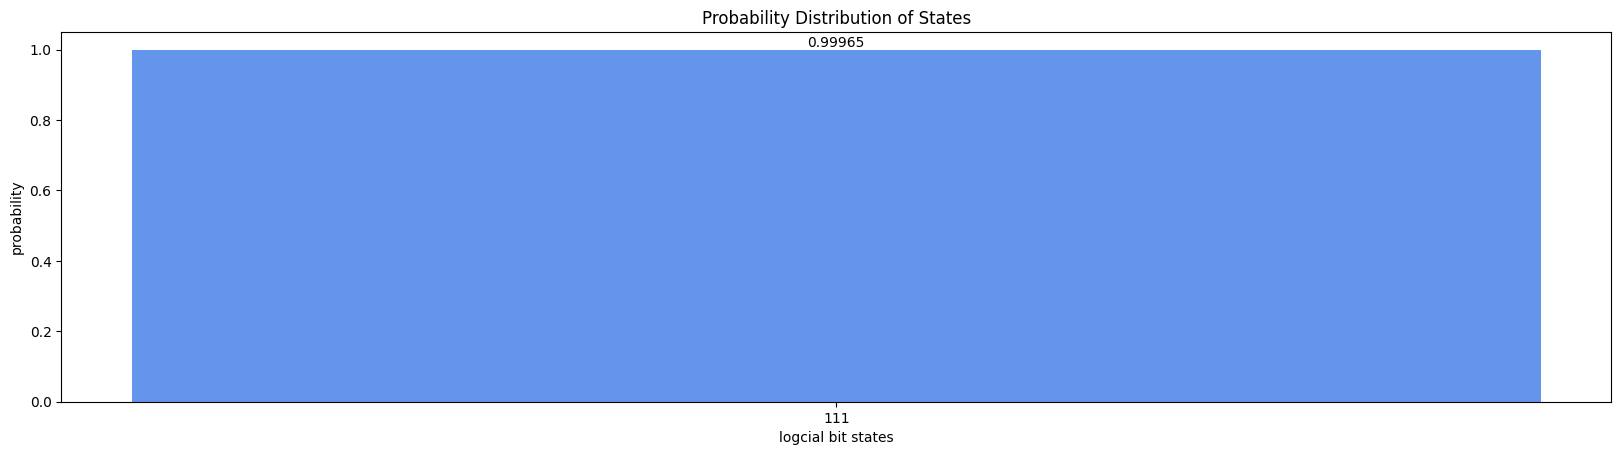

In [4]:
# 2 adjacent qubits all-to-all connectivity CNOT gate example #
cnot_gate = CNOT(0, 1, 3) # CNOT gate with q0 as control and q1 as target

rho_prime = np.dot(cnot_gate, np.dot(rho, cnot_gate.conj().T)) # apply our 'perfect' cnot gate

final_rho = qubit_rad_error_matrix(rho_prime, t1, t2, tg) # apply our error gate

# probability of the state measurments from the density matrix are defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(final_rho)):
    prob_sum += np.abs(final_rho[i,i])
    state_probs = np.append(state_probs, final_rho[i,i])
    
print('total probability: ', prob_sum)

bits = vector_state_to_bit_state(state_probs, 3)[0]

# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, state_probs[state_probs!=0], label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

total probabilities:  0.9996500616593808


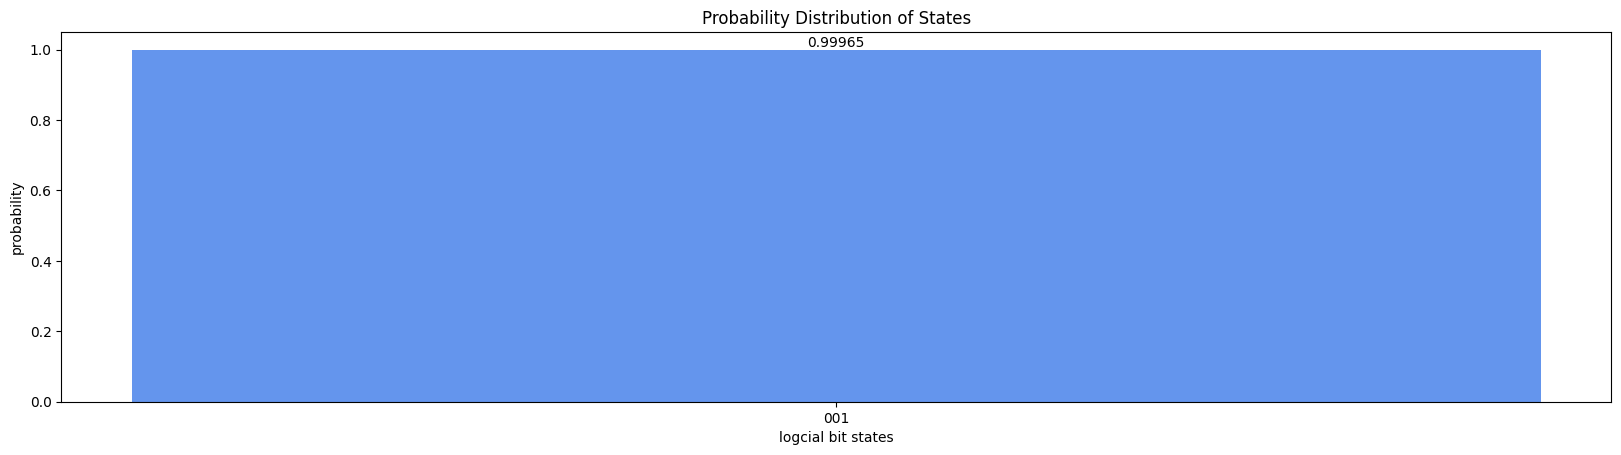

In [5]:
# 2 non-adjacent qubits all-to-all connectivity CNOT gate example #
cnot_gate = CNOT(2, 0, 3) # CNOT gate with q2 as control and q0 as target

rho_prime = np.dot(cnot_gate, np.dot(rho, cnot_gate.conj().T)) # apply our cnot gate

final_rho = qubit_rad_error_matrix(rho_prime, t1, t2, tg) # apply our error gate

# probability of the state measurments from the density matrix are defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(final_rho)):
    prob_sum += np.abs(final_rho[i,i])
    state_probs = np.append(state_probs, final_rho[i,i])
    
print('total probabilities: ', prob_sum)

bits = vector_state_to_bit_state(state_probs, 3)[0]

# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, state_probs[state_probs!=0], label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

Now we will implement <u>line connectivity</u>.<a id='linerad'></a> This will mean that each gate operation will implement an error and we will see the effects after multiple gates have occured.

total probability:  0.9986009812071819


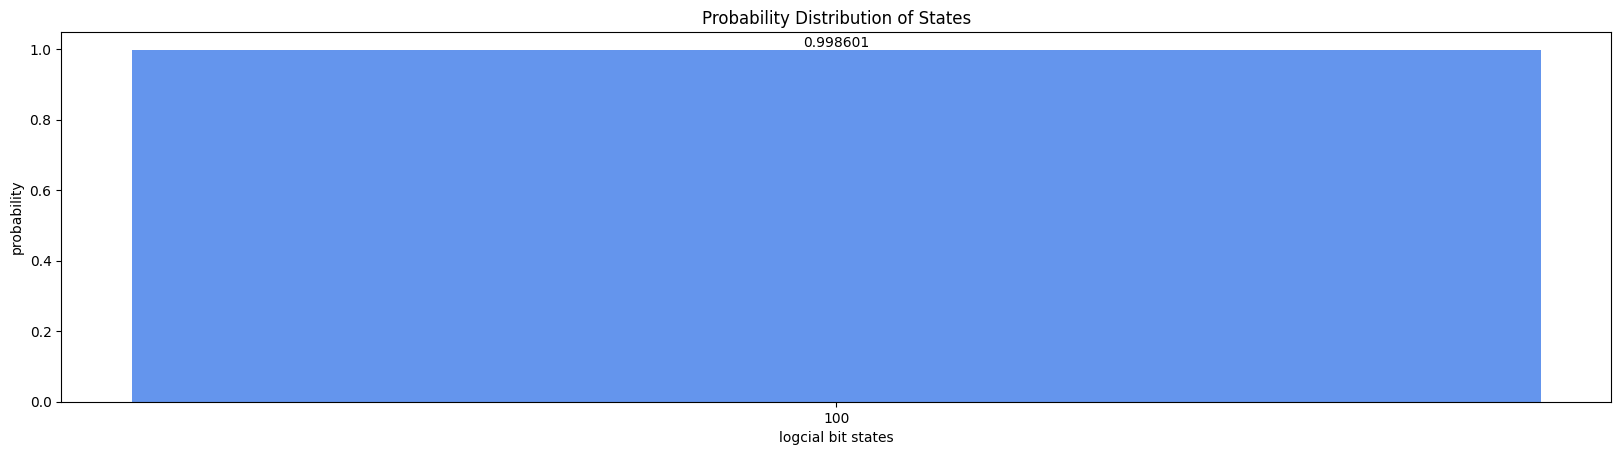

In [6]:
# 2 non-adjacent qubits line connectivity CNOT gate example #
# CNOT gate with q0 as control and q2 as target
psi = np.kron(one, np.kron(zero, one))

# parameters set for all qubits:
t1 = 200 * 10**-6
t2 = 150 * 10**-6
tg = 20 * 10**-9

# apply an errored line connected CNOT gate
rho_prime = line_rad_CNOT(psi, 0, 2, t1, t2, tg, form = 'psi') 

# probability of the density matrix is defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(rho_prime)):
    prob_sum += np.abs(rho_prime[i,i])
    state_probs = np.append(state_probs, rho_prime[i,i])
    
print('total probability: ', prob_sum)
bits = vector_state_to_bit_state(state_probs, 3)[0]

# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, state_probs[state_probs!=0], label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

total probability:  0.9930244512084462


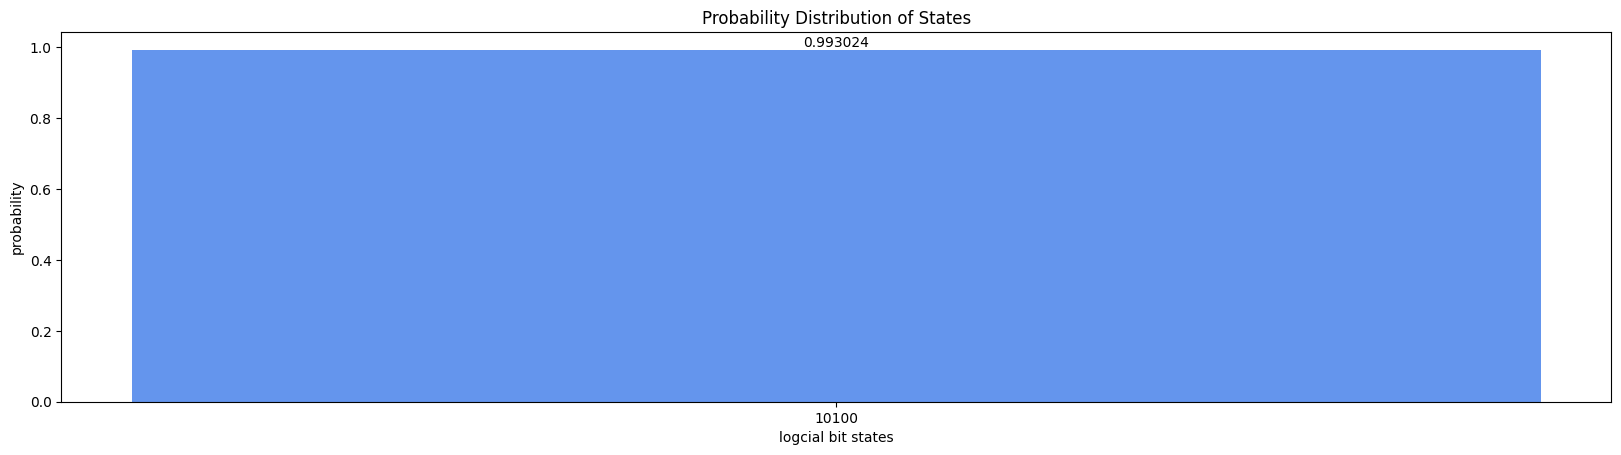

In [7]:
# 2 non-adjacent qubits line connectivity CNOT gate example with 5 qubits #
# CNOT gate with q0 as control and q4 as target
psi = np.kron(one, np.kron(zero, np.kron(one, np.kron(zero, one))))

# parameters set for all qubits:
t1 = 200 * 10**-6
t2 = 150 * 10**-6
tg = 20 * 10**-9

# apply an errored line connected CNOT gate
rho_prime = line_rad_CNOT(psi, 0, 4, t1, t2, tg, form = 'psi')

# probability of the density matrix is defined as Tr(p*rho)
prob_sum = 0
state_probs = np.array([])
for i in range(len(rho_prime)):
    prob_sum += np.abs(rho_prime[i,i])
    state_probs = np.append(state_probs, rho_prime[i,i])
    
print('total probability: ', prob_sum)
bits = vector_state_to_bit_state(state_probs, 5)[0]

# Plotting the error state probabilities
fig, ax = plt.subplots()
fig.set_figwidth(20)
error_state_bars = ax.bar(bits, state_probs[state_probs!=0], label = 'States Probability Distribution', color = 'cornflowerblue')
plt.title('Probability Distribution of States')
plt.xlabel('logcial bit states') 
plt.ylabel('probability') 
ax.bar_label(error_state_bars)
plt.show()

We can also apply the above gate many times and see the resulting qubit population decay overtime due to the errors that occur at each gate operation.

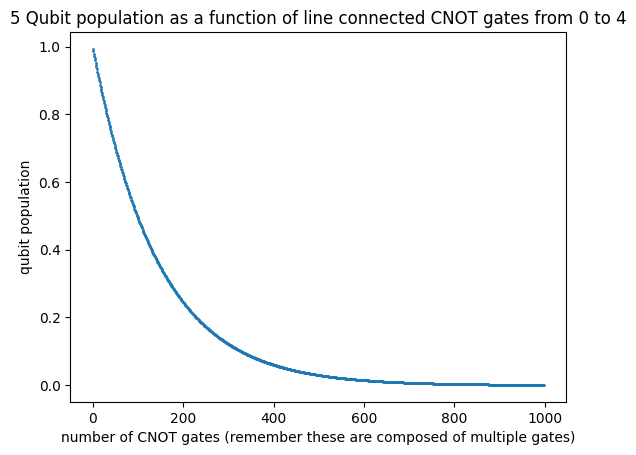

In [8]:
# CNOT gate with q0 as control and q2 as target
psi = np.kron(one, np.kron(zero, np.kron(one, np.kron(zero, one))))

# parameters set for all qubits:
t1 = 200 * 10**-6
t2 = 150 * 10**-6
tg = 20 * 10**-9

sums = np.array([])
count = np.array([])

for i in range(999):
    count = np.append(count, i)

    if i == 0:
        # apply an errored line connected CNOT gate
        rho_prime = line_rad_CNOT(psi, 0, 4, t1, t2, tg, form = 'psi')
    else:
        # apply an errored line connected CNOT gate
        rho_prime = line_rad_CNOT(rho_prime, 0, 4, t1, t2, tg, form = 'rho')
        
    # probability of the density matrix is defined as Tr(p*rho)
    prob_sum = 0
    state_probs = np.array([])
    for i in range(len(rho_prime)):
        prob_sum += np.abs(rho_prime[i,i])
        state_probs = np.append(state_probs, rho_prime[i,i])

#     print('total probability: ', prob_sum)
    sums = np.append(sums, prob_sum)
    
    
plt.scatter(count, sums, s = 1)
plt.title('5 Qubit population as a function of line connected CNOT gates from 0 to 4')
plt.xlabel('number of CNOT gates (remember these are composed of multiple gates)')
plt.ylabel('qubit population')
plt.show()
